To notepad αυτό αποτελεί ένα "hello-world" για την χρήση της βιβλιοθήκης [mOWL](https://mowl.readthedocs.io/en/latest/index.html). Ο σκοπός είναι να στηθεί ένα απλό παράδειγμα που επιδεικνύει τη χρήση της mOWL για την αναγνώριση "ακμών" ενός γράφου γνώσης (ΓΓ).

**Προσοχή: Eάν το notebook τρέχει στο google colab, πρέπει να επιλεχθεί από το menu, η επιλογή Runtime -> Change runtime type και να επιλεχθεί ένα διαθέσιμο GPU. Αυτό γίνεται γιατί τα μοντέλα τρέχουν με χρήση CUDA, για γρηγορότερο χρόνο εκπαίδευσης** </h5>

In [ ]:
!pip install mowl-borg


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Αρχικοποίηση
Αρχικά εισάγεται η βιβλιοθήκη mowl και η torch
και αρχικοποιείται η διαθέσιμη προς χρήση μνήμη για το Java Virtual Machine ως 10 Gigabytes. <br>
Η βιβλιοθήκη [mOWL](https://mowl.readthedocs.io/en/latest/) είναι μια βιβλιοθήκη που έχει σχεδιαστεί για να υποστηρίζει τη Μηχανική Μάθηση με Οντολογίες, προσφέροντας λειτουργίες για τη διαχείριση οντολογιών και τη δημιουργία αναπαραστάσεων σε μορφή διανυσμάτων (embeddings) για τις οντότητες τους. Αξιοποιεί την [OWLAPI](https://github.com/owlcs/owlapi/wiki/Documentation), μια βιβλιοθήκη γραμμένη σε Java, μέσω του JPype και για αυτό τον λόγο είναι αναγκαία και η αρχικοποίηση μνήμης στο JVM.
Η [Torch](https://pytorch.org/docs/stable/index.html) παρέχει ισχυρά εργαλεία για την εκπαίδευση και τη χρήση αλγορίθμων μηχανικής μάθησης και νευρωνικών δικτύων.

In [ ]:
import mowl
mowl.init_jvm("10g")
import torch as th

### Dataset που χρησιμοποιείται:
Το dataset που χρησιμοποιείται είναι το [PPIYeastDataset](https://mowl.readthedocs.io/en/latest/api/mowl.datasets.builtin.PPIYeastDataset.html#mowl.datasets.builtin.PPIYeastDataset) το οποίο είναι built-in στη βιβλιοθήκη mowl. Το dataset αυτό περιλαμβάνει protein-protein interactions που αφορούν τον συγκεκριμένο μύκητα και οι σχέσεις μεταξύ πρωτεϊνών αναπαραστούνται σαν αξιώματα με τον παρακάτω τρόπο: <br>
<b>protein1 ⊆ interacts_with.protein2</b>
Το dataset αποθηκέυεται σε έναν φάκελο με 3 αρχεία τύπου "*.owl" κατά την εκτέλεση του προγράμματος. Στον φάκελο αυτό περιέχονται τα εξής: "ontology.owl" το οποίο εισάγεται σαν είσοδος στο στάδιο εκπαίδευσης των μοντέλων, "valid.owl" για την επικύρωση του μοντέλου (παραγωγή κάποιου loss) στα στάδια της εκπαίδευσης και "test.owl" για την τελική αξιολόγηση των embeddings. <br>
Η δομή του dataset αποτελείται κυρίως από κλάσεις στην owl (πχ http://4932.Q0045 , όπου το 4932.Q0045 είναι το identifier της πρωτείνης), σε ποιά ευρύτερη κατηγορία κλάσεων προτείνων (subClassOf) ανήκουν, διάφορα restrictions και properties, όπως και το αντικείμενο κορμού στην μελέτη PPI, interacts_with που συνδέει 2 κλάσεις πρωτεινών μεταξύ τους. <br>
<b> Για παράδειγμα: </b> <br>
Η πρωτεΐνη 4932.Q0045 που αναφέρθηκε πάνω, γνωστή και ως [COX1](https://string-db.org/network/4932.Q0045), με την ιδιότητα "interacts_with", φαίνεται να αλληλεπιδρά με την προτείνη 4932.Q0050, γνωστή και ως [Saccharomyces cerevisiae](https://string-db.org/network/4932.Q0050) : <br>

    <owl:Class rdf:about="http://4932.Q0045">
        ...
        <rdfs:subClassOf>
            <owl:Restriction>
                <owl:onProperty rdf:resource="http://interacts_with"/>
                <owl:someValuesFrom rdf:resource="http://4932.Q0050"/>
            </owl:Restriction>
        </rdfs:subClassOf>
        ...
    </owl:Class>


Αντιστοίχως λοιπόν, και η πρωτεΐνη 4932.Q0050 συνδέεται ρητά με την 4932.Q0045, με χρήση του ίδιου property:

    <owl:Class rdf:about="http://4932.Q0050">
        ...
        <rdfs:subClassOf>
            <owl:Restriction>
                <owl:onProperty rdf:resource="http://interacts_with"/>
                <owl:someValuesFrom rdf:resource="http://4932.Q0045"/>
            </owl:Restriction>
        </rdfs:subClassOf>
        ...
     </owl:Class>
Για την 4932.Q0045 στο ontology.owl περιέχονται 55 αλληλεπιδράσεις με άλλες πρωτείνες. Στο valid.owl, παρέχονται μόνο 2 και στο test.owl 6, εκ των οποίων καμία δεν είναι παρούσα στο ontology.owl. Αυτή η αναλογία δεν δεν είναι σταθερή από κλάση σε κλάση και γενικά [οι αλληλεπιδράσεις χωρίστικαν τυχαία](https://mowl.readthedocs.io/en/latest/api/mowl.datasets.builtin.PPIYeastDataset.html#mowl.datasets.builtin.PPIYeastDataset), ώστε το 90% αυτών να είναι στο αρχείο ontology.owl, το 5% στο valid.owl και το υπόλοιπο 5% στο test.owl. Το γεγονός επίσης ότι οι αλληλεπιδράσεις του ontology.owl δεν εμφανίζονται στα άλλα 2 αρχεία είναι ιδιαίτερα σημαντικό, καθώς ο στόχος των μοντέλων είναι το link prediction. Δηλαδή, κάθε φορά που γίνεται το στάδιο του validation, το μοντέλο προσαρμόζεται ώστε να "μαντεύει" καλύτερα αν προτείνες αλληλεπιδρούν με άλλες με βάση τις νέες αλληλεπιδράσεις του valid.owl. Τέλος στο στάδιο αξιολόγησης του μοντέλου, ελέγχεται κατά πόσο προβλέπονται οι αλληλεπιδράσεις του test.owl από το ontology.owl.

***
Αριθμός προτεϊνών στο ontology.owl: 6033

Αριθμός αλληλεπιδράσεων πρωτεϊνών στο ontology.owl: 433390

Αριθμός προτεϊνών στο valid.owl: 3635

Αριθμός αλληλεπιδράσεων πρωτεϊνών στο valid.owl: 24078

Αριθμός προτεϊνών στο test.owl: 3665

Αριθμός αλληλεπιδράσεων πρωτεϊνών στο test.owl: 24082
***

![](https://mermaid.ink/img/pako:eNqNU8Fq20AQ_ZVhe0nAKjn1IEggiazk0J4aemjVw9ZaySLSbpBXTU0IJG1NKeRSaC-lt-SYNhjbGMdx_QerX-pbqXYTQksRi2Zn33u8md05Yi0VCuYyx3EC2VIySmI3kEQp76pCuxQlb0RoE7otMuGSFMoJeb4fyIoRpeqw1ea5pj3Poog2XwRMSa1SFXcfqsOUVvZynshExuRxzVcD9pIcZ4O2gDNfTb98by7NFN_YLipPylMzNyOk52ZibgB4Z65Mn5AYl28J2Vl1NsUa2BObHADaJzMyE6D7ZlB-ROoHYTMiaNSc75az0MlgDVZqz1uVo23r6Iu5Lk8gcWWGMNGDwpjMtz8KUJ7RClx-oObjZvZKhCFK66wutbYrLc9qfUZNN3A2h85pbZbEkrJkeBXDt4zzqhtDyyFYmVXhJURG1oit9JP5aU9h5AyK40X6To1l75b2-voG7VrtC7RnCu41GoMC78mgfah8Yoblme1bVajtdNn7u3wTwq95moT1TT-zIdeJknfv2q_RO0Br0dG_nwWie69it0b69YXUm47upoI28c_VvnAf-P4jb22tESVputjcBjb_F7jzbyBrsEzkGU9CjMeRJcK9HYKAuQirIWCBPAaOF1o97coWc3VeiAbLVRG3mRvxtINdcYCeCC_hcc6zBeSAy-dKZUuQCBOt8if1MFYzefwL1_idzg)

## EL-embedding μοντέλο
H mOWL μπορεί να παράξει embeddings με πολλούς τρόπους. Το [EL-embedding μοντέλο](https://mowl.readthedocs.io/en/latest/examples/elmodels/plot_1_elembeddings.html#sphx-glr-examples-elmodels-plot-1-elembeddings-py), είναι ένας από αυτούς.
Το [EL profile](https://www.w3.org/TR/owl2-profiles/#OWL_2_EL), είναι ένα lightweight profile της OWL που υποστηρίζει βασικές εκφράσεις Descriptions Logic, καθιστώντας το ιδιαίτερα χρήσιμο για μεγάλα datasets με απλές ιεραρχίες.

Το EL profile βασίζεται στα εξής General Concept Inclusions (GCIs):

**GCI 0** - `C ⊑ D`: Περιγράφει ότι κάθε στοιχείο της κλάσης 𝐶 ανήκει και στην κλάση D. Ουσιαστικά, είναι η σχέση "subclassOf" της OWL.<br>
**GCI 1** - `C1 ⊓ C2 ⊑ D`: Περιγράφει ότι αν κάτι ανήκει στην κλάση C1 και στην κλάση C2, τότε ανήκει και στην κλάση D. To EL profile μπορεί να υποστηρίξει τομή δύο κλάσεων.<br>
**GCI 2** - `C ⊑ ∃R.D`: Περιγράφει ότι όλα τα μέλη της κλάσης C πρέπει να έχουν μια σχέση R με τουλάχιστον ένα αντικείμενο που ανήκει στην κλάση D. Το EL profile μπορεί να υποστηρίξει σχέσεις (properties) μεταξύ κλάσεων και individuals.<br>
**GCI 3** - `∃R.C ⊑ D`: Περιγράφει ότι αν υπάρχει μια σχέση R που συνδέει κάποιο αντικείμενο με ένα μέλος της κλάσης C, τότε το αντικείμενο αυτό ανήκει στην κλάση D.<br>
**GCI bot 0** - `C ⊑ ⊥`: Περιγράφει ότι δεν υπάρχει κάποιο αντικείμενο στην κλάση C - μπορεί να υπάρξει κενή κλάση.<br>
**GCI bot 1** - `C1 ⊓ C2 ⊑ ⊥`: Περιγράφει ότι μπορεί η τομή των κλάσεων C1 και C2 να είναι κενή<br>
**GCI bot 3** - `∃R.C ⊑ ⊥`: Περιγράφει ότι δεν υπάρχει αντικείμενο που να έχει μια σχέση R προς κάτι που ανήκει στην κλάση C.<br>

όπου τα C1, C2, D είναι κλάσεις, το R αντιστοιχεί σε μια ιδιότητα.
Ουσιαστικά, τα GCIs αποτυπώνουν τους "κανόνες" που μπορούμε να χρησιμοποιήσουμε για να περιγράψουμε γνώση με το συγκεκριμένο OWL profile.

Σύμφωνα με το σχετικό [paper](https://www.ijcai.org/proceedings/2019/845), το EL embedding μοντέλο αποσκοπεί στο να μεταφέρει τις κλάσεις και τις σχέσεις σε μια γεωμετρική διάσταση (όπως έναν n-διάστατο πραγματικό χώρο). Ο στόχος είναι να διατηρηθεί η σημασιολογική δομή της οντολογίας μέσα σε αυτόν τον γεωμετρικό χώρο.
Για να επιτευχθεί αυτό η mOWL αντιστοιχίζει κάθε κλάση σε μια n-διάστατη σφαίρα ("μπάλα"). Η n-μπάλα που αντιστοιχεί στην κλάση C1 περικλείει όλα τα individuals της κλάσης. Κάθε σημείο της "υπερσφαίρας" αυτής αποτελεί ένα από τα individuals της κλάσης. Με αυτή τη λογική, αν μια κλάση είναι υποκλάση μιας άλλης, η αντίστοιχη n-μπάλα που αναπαριστά την πρώτη κλάση (υποκλάση) θα πρέπει να βρίσκεται μέσα στην n-μπάλα της δεύτερης (υπερκλάση).

Οι σχέσεις μεταξύ κλάσεων (object properties) αντιστοιχίζονται σε διανύσματα σε αυτόν τον n-διάστατο χώρο. Ας υποθέσουμε ένα object property P που διασυνδέει τα individuals c της κλάσης C και d της κλάσης D. Αυτή η σχέση θα αποτυπωθεί στον διανυσματικό χώρο του μετασχηματισμού σαν ένα διάνυσμα που ενώνει δύο σημεία τα οποία περικλείονται από τις αντίστοιχες n-μπάλες που αποτελούν τον μετασχηματισμό της κλάσης C και της κλάσης D.

Το μοντέλο εκμάθησης χρησιμοποιεί συναρτήσεις απώλειας για να διασφαλίσει ότι η γεωμετρική αναπαράσταση της οντολογίας διατηρεί τις λογικές σχέσεις μεταξύ των κλάσεων και των σχέσεων.
Ορίζεται λοιπόν για κάθε ένα GCI μια συνάρτησης απώλειας και το άθρισμα των απωλειών για κάθε μετασχηματισμό κάθε μιας από τις κλάσεις χρησιμοποιείται για την δυνατόν καλύτερη προσαρμογή των σφαιρών στους κανόνες του EL Profile.  

Ως παράδειγμα, υπάρχει ένα μοντέλο που χρησιμοποιείται για να μοντελοποιήσει τις σχέσεις των PPIs. Το μοντέλο αυτό είναι ένα μοντέλο τύπου EL-embedding ([ELEmPPI](https://mowl.readthedocs.io/en/latest/_modules/mowl/models/elembeddings/examples/model_ppi.html#ELEmPPI)) αλλά παρέχεται και ένα γενικότερο μοντέλο που μπορεί να προσαρμοστεί για οποιοδήποτε dataset. <br>



## [Εκπαίδευση μοντέλου EL embedding](https://mowl.readthedocs.io/en/latest/api/mowl.models.ELEmbeddings.html#mowl.models.ELEmbeddings)
Τα δεδομένα στην αρχή υπάρχουν ως τριπλέτες και διαχωρίζονται με κριτήριο το GCI που αντιπροσωπεύουν. Έπειτα μετατρέπεται το κάθε κομμάτι της τριπλέτας σε ένα n-διάστατο embedding τυχαία αρχικοποιημένο. Έπειτα, για τον πιο ακριβής ορισμό του μοντέλου, δημιουργούνται και αρνητικά δείγματα για το GCI που μας ενδιαφέρει (στην συγκεκριμένη περίπτωση το GCI2), όπου αντικαθίσταται το τρίτο μέρος της τριπλέτας με κάποια άλλη τυχαία επιλογή και ορίζεται ως ψευδή σχέση. Η παρακάτω μεθοδολογία ονομάζεται negative sampling.
Αφού μετατραπούν και τα negative samples σε embeddings, κατά την διάρκεια κάθε εποχής, το μοντέλο τα ενημερώνει με στόχο την **ελαχιστοποίηση της συνάρτησης απώλειας**.
Στην συγκεκριμένη εφαρμογή, η συνάρτηση που μας αποσχωλεί κυρίως είναι η gci2_loss και αποτελείται από 2 μέρη.
$$
\text{loss}_{C \subseteq \exists R.D }(c, d, r) = \max\Big(0,\; \|f(c) + f(r) - f(d)\| + r(c) - r(d) - \gamma\Big)
+ \Big|\|f(c)\| - 1\Big| + \Big|\|f(d)\| - 1\Big|
$$
Στο πρώτο μέρος ο στόχος είναι η μετατώπιση του κέντρου της n-μπάλας C + την σχέση R ώστε να εμπείπτει μέσα στην n-μπάλα D.

Επιπλέον, αν η r(c) (ακτίνα της C) είναι πολύ μεγάλη σε σχέση με την r(d), τότε αυτό δείχνει ότι το "εμβαδόν" της C δεν είναι συμβατό με το να συμπεριλιφθεί μέσα στην D. Οπότε ο όρος r(c)−r(d) προστίθεται στην απόσταση που υπολογίζεται παραπάνω (f(c)+f(r)-f(d)), ώστε να υπάρξει ποινή (loss) όταν η μπάλα C δεν είναι εντός της μπάλας της D (το γ είναι ένα περιθώριο ασφάλειας).
Το δεύτερο μέρος της συνάρτησης έχει ρόλο κανονικοποίησης. Δηλαδή, διασφαλίζει ότι τα embeddings των κατηγοριών δεν αποκλίνουν από την μονάδα.

Tέλος, μετά από κάθε epoch, υπολογίζεται η συνάρτηση απώλειας στα δεδομένα του validation set (όπου δεν έχει εκπαιδευτεί) χωρίς να γίνονται ενημερώσεις στα embeddings με σκοπό την αξιολόγηση ικανότητας γενίκευσης του μοντλέλου μετά από κάθε εποχή και τον έλεγχο υπερπροσαρμογής του.




---



Στις παραμέτρους του ELEmPPI μπορούν να δοκιμαστούν διάφορες τιμές για κάθε όρισμα. <br>
Η έξοδος μετά την εκπέδευση, αποθηκέυται στις τιμές model.class_embeddings και model.object_property_embeddings και είναι τυπου dictionaries. Το  model.class_embeddings περιέχει τα ονόματα των κλάσεων και το embedding τους, και το model.object_property_embeddings τις ιδιότητες με τα αντίστοιχα embeddings για την κάθε μία από αυτές.

In [ ]:
import logging
from mowl.datasets.builtin import PPIYeastDataset
from mowl.models import ELEmPPI

# logging να αγνοεί τα info μηνύματα
logging.basicConfig(level=logging.WARNING)

# dataset που χρησιμοποιείται (το συγκεκριμένο είναι built-in)
dataset = PPIYeastDataset()

# initialize model with the required parameters
model = ELEmPPI(dataset, #το dataset που χρησιμοποιείται για εκπέδευση (στο συγκεκριμένο μέσα στο ELemPPI παίρνει το training κομμ΄άτι του και τα GCIs αυτού
                embed_dim=256, #διάσταση των embedding
                learning_rate=0.0003,#ρυθμός μάθησης (ρυθμός ενημέρωσης παραμέτρων εκπέδευσης σε κάθε βήμα)
                epochs=400,#αριθμός εποχών (δλδ πλήρης επαναλήψεων εκπέδευσης)
                batch_size=2048, #τα δείγματα που επεξεργάζονται σε κάθε βήμα
                model_filepath=None,
                device='cuda') #Χρήση cuda (gpu) για γρηγορότερους υπολογισμούς στο training

#κλήση μεθόδου εκπέδευσης
model.train()


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:06<00:00,  3.17it/s]


1

## Evaluation

To evaluation των embeddings διαφέρει ανάλογα με το dataset. Στο συγκεκριμένο παράδειγμα, χρησιμοποιείται το PPIYeastDataset και το built-in [PPIEvaluator](https://mowl.readthedocs.io/en/latest/api/mowl.evaluation.PPIEvaluator.html#mowl.evaluation.PPIEvaluator). <b> Κάθε κλάση Evaluator χαρακτηρίζεται από δύο κύρια σημεία: τον τύπο των οντοτήτων που εμπλέκονται και τον τύπο των αξιωμάτων που θα αξιολογηθούν. </b> Στην περίπτωση του PPIEvaluator, οι εμπλεκόμενες οντότητες είναι μόνο αυτές που εκπροσωπούν πρωτεΐνες, χωρίς να λαμβάνονται υπόψη άλλες οντότητες. Τα αξιώματα που αξιολογούνται με τον PPIEvaluator είναι του τύπου "p1 αλληλεπιδρά με p2" (εξού και το PPI όνομα). Κάθε dataset έχει τη δική του ιδιότητα evaluation_classes, όπου καθορίζει τι είδους οντότητες ή αξιώματα θα εξεταστούν από το dataset στο πλαίσιο της αξιολόγησης. <br>


Κατά τη διαδικασία της αξιολόγησης δημιουργούνται υποψήφιες τριάδες αντικαθιστώντας το στοιχείο που επιδιώκεται να προβλεφθεί με όλα τα πιθανά candidates πρωτεινών.

Συγκεκριμένα, για την πρόβλεψη του tail, από κάθε αρχική τριάδα (head, rel, tail) το tail αφαιρείται, πράγμα που σημαίνει ότι το head και η σχέση (rel) επαναλαμβάνονται και για κάθε μία από τις οντότητες στο evaluation set (self.evaluation_tails), δημιουργείται μια νέα τριάδα (head, rel, candidate_tail), επιτρέποντας στο μοντέλο να υπολογίσει scores για κάθε candidate tail.

Τα scores αυτά για κάθε τριπλέτα υπολογίζονται με την χρήση των ίδιων συναρτήσεων απώλειας που χρησιμοποιούνται και στο train στάδιο (στο συγκεκριμένο παράδειγμα άρα την gci2_loss), και ύστερα ταξινομούνται σε αύξουσα σειρά, ώστε οι τριπλέτες με το μικρότερο loss να θεωρούνται πιο πιθανές.

Αντίστοιχα, για την πρόβλεψη του head, αφαιρείται το head από κάθε τριάδα, ενώ το tail και η σχέση επαναλαμβάνονται, με το head να αντικαθίσταται από κάθε υποψήφιο head στο evaluation set (self.evaluation_heads). Έπειτα ξανά υπολογίζονται τα loss για κάθε τριπλέτα και ταξινομούται με βάση αυτά.



    heads = heads.repeat_interleave(len(self.evaluation_tails)).unsqueeze(1)
    rels = rels.repeat_interleave(len(self.evaluation_tails)).unsqueeze(1)
    eval_tails = th.arange(len(self.evaluation_tails), device=heads.device).repeat(num_heads).unsqueeze(1)

     
    logits_heads = model(th.cat([heads, rels, eval_tails], dim=-1), "gci2")
    logits_heads = logits_heads.view(-1, len(self.evaluation_tails))
        
    tails = tails.repeat_interleave(len(self.evaluation_heads)).unsqueeze(1)
    eval_heads = th.arange(len(self.evaluation_heads), device=tails.device).repeat(num_tails).unsqueeze(1)

    logits_tails = model(th.cat([eval_heads, rels, tails], dim=-1), "gci2")
    logits_tails = logits_tails.view(-1, len(self.evaluation_heads))
    # print(logits_heads, logits_tails)

Με αυτόν τον τρόπο, η διαδικασία αξιολόγησης μετρά την ικανότητα του μοντέλου να προβλέπει σωστές αλληλεπιδράσεις (link prediction), δηλαδή ποια οντότητα συμπληρώνει καλύτερα το κενό σε μια τριάδα σε σχέση με το σύνολο των πιθανών επιλογών.

Μετά την τελική αξιολόγηση στο test set, αποθηκεύονται στο model.metrics διάφορες μετρικές για το πόσο καλά κατατάσει το μοντέλο τις σωστές πρωτείνες στις ελλιπείς τριπλέτες. Μια από αυτές τις μετρικές είναι η
[hits@k](https://pykeen.readthedocs.io/en/stable/api/pykeen.metrics.ranking.HitsAtK.html).
Συγκεκριμένα, μετρά το ποσοστό των περιπτώσεων όπου η σωστή οντότητα (π.χ. η σωστή πρωτεΐνη) εμφανίζεται μεταξύ των κορυφαίων k προβλεπόμενων οντοτήτων για κάθε δοσμένη ελλιπής τριπλέτα. Η τιμή της μετρικής κυμαίνεται από 0 έως 1, με τιμές πλησιέστερες στο 1 να υποδεικνύουν καλύτερη απόδοση του μοντέλου.

Για παράδειγμα:

Σε ένα σύνολο 100 ελλιπών τριπλετών (head, relation, ?)), για k = 10, αν σε 85 από τις 100 ελλιπείς τριπλέτες η σωστή πρωτεΐνη εμφανίζεται μέσα στα 10 πρώτα candidate_tails, τότε:

hits@10 = 85/100 = 0.85

Αυτό σημαίνει ότι σε 85% των περιπτώσεων το μοντέλο κατάφερε να συμπεριλάβει την σωστή πρωτεΐνη μέσα στο top-10 των επιλογών του.

Βέβαια, μια πιο ευνόητη μετρική είναι η [Mean Rank](https://pykeen.readthedocs.io/en/stable/api/pykeen.metrics.ranking.ArithmeticMeanRank.html#pykeen.metrics.ranking.ArithmeticMeanRank), όπου δίνει την μέση θέση που βρίσκεται η σωστή πρόβλεψη για τις ελλιπείς τριπλέτες.

In [ ]:
from mowl.evaluation import PPIEvaluator
model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)

data1 = model.metrics #αποθήκευση αποτελεσμάτων για το ELembedding
print(data1)

{'mr': 490.4119601328904, 'mrr': 0.02747791769470102, 'f_mr': 490.4119601328904, 'f_mrr': 0.02747791769470102, 'auc': 0.9189446902727906, 'f_auc': 0.9189446902727906, 'hits@1': 0.0004152823920265781, 'hits@3': 0.00872093023255814, 'hits@10': 0.06229235880398671, 'hits@50': 0.3267441860465116, 'hits@100': 0.47483388704318935, 'f_hits@1': 0.0004152823920265781, 'f_hits@3': 0.00872093023255814, 'f_hits@10': 0.06229235880398671, 'f_hits@50': 0.3267441860465116, 'f_hits@100': 0.47483388704318935}


### Οπτικοποίηση αποτελεσμάτων ###

Για την απεικόνιση των embedding, η έτοιμη κλάση TSNE της mowl, δεν είναι επαρκής, καθώς δεν αναφέρει το όνομα της κάθε κλάσης κάτω από τις βούλες στην αναπαράσταση, και χρησιμοποιεί ένα legend. Παρόλα αυτά, όταν έχουμε πολλές διαφορετικές κλάσεις, όπως και με τα PPI, όπου κάποιες αναγκαστικά θα έχουν το ίδιο χρώμα, το legend είναι απρόσφορο.

INFO:root:Found 50 embedding vectors. Processing only 50.
C:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*

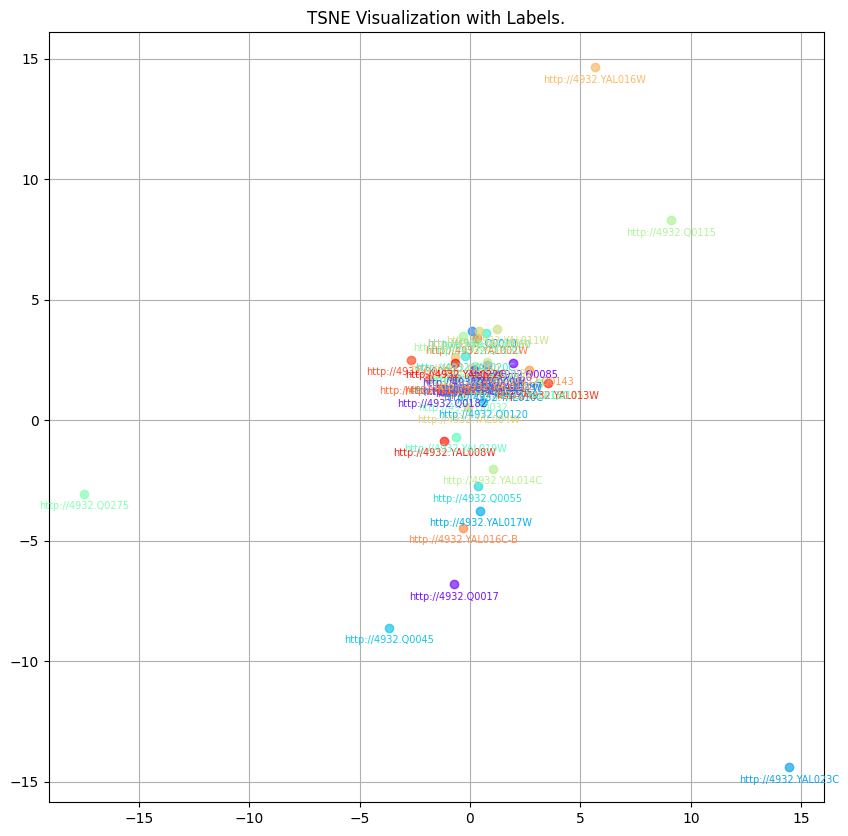

In [ ]:

import matplotlib.pyplot as plt
from mowl.visualization import TSNE

class CustomTSNE(TSNE):
    def show(self, figsize=(10, 10), alpha=0.5, fontsize=9):

        points = self.points
        labels = self.labels

        if points is None:
            raise ValueError("You need to call generate_points() first.")

        plt.figure(figsize=figsize)

        for i, label in enumerate(labels):
            #color = label_to_color[label]
            color = self.class_color_dict[label]
            plt.scatter(points[i, 0], points[i, 1], color=color, alpha=0.7) #alpha= opacity
            plt.text(points[i, 0], points[i, 1] - 0.3, label, fontsize=7,  #fontisze = label size
                     ha='center', va='top', color=color)                    #  points[i,1]-0.3 = change -0.3 to make the label go lower or higher

        plt.title("TSNE Visualization with Labels.")
        plt.grid(True)
        plt.show()



class_embeddings = model.class_embeddings #dict με ονόματα κλάσεων δλδ προτεινών και το αντίστοιχο embedding τους.
#για το plot χρησιμοποιούνται τα 50 πρώτα classes
limited_class_embeddings = dict(list(model.class_embeddings.items())[:50])
res = dict((k,k) for k,v in limited_class_embeddings.items())
tsne = CustomTSNE(limited_class_embeddings, res) #εργαλείο για μείωση των διαστάσεων σε 2, για λόγους οπτικοποίησης
tsne.generate_points(250, workers=4)
tsne.show()


## [ELBox Embedding](https://mowl.readthedocs.io/en/latest/examples/elmodels/plot_2_elboxembeddings.html#sphx-glr-examples-elmodels-plot-2-elboxembeddings-py)
Στην περίπτωση των EL Embeddings, τα γεωμετρικά αντικείμενα που αναπαριστούν τις κλάσεις της οντολογίας είναι μπάλες n-διαστάσεων. Ένα από τα GCI στην EL είναι: <br>
`C1 ⊓ C2 ⊑ D'
Όπως είναι φανερό, σε αυτό το GCI, υπάρχει μια πράξη τομής . Η υπολογιστική αυτή τομή χρησιμοποιώντας μπάλες δεν είναι μια κλειστή πράξη διότι η περιοχή που περιέχεται στην τομή δύο μπαλών δεν είναι μπάλα. Για να λυθεί αυτό το ζήτημα, μπορεί να χρησιμοποιηθεί ένας άλλος τρόπος να παράξουμε embeddings ο οποίος αντί για n-μπάλες μετατρέπει τις κλάσεις σε n-κύβους για τους οποίους η πράξη της τομής έχει την ιδιότητα της κλειστότητας. Aυτό γίνεται με το έτοιμο μοντέλο [ELBoxPPI](https://mowl.readthedocs.io/en/latest/_modules/mowl/models/elboxembeddings/examples/model_ppi.html#ELBoxPPI) της mowl, αντιστοίχως.


In [ ]:
from mowl.models.elboxembeddings.examples.model_ppi import ELBoxPPI
model = ELBoxPPI(dataset,
                 embed_dim=256,
                 learning_rate=0.0003,
                 epochs=400,
                 batch_size=2048,
                 model_filepath=None,
                 device='cuda')
model.train()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [23:20<00:00,  3.50s/it]


1

Εδώ χρησιμοποιείται για άλλη μια φορά το built-in evaluator για PPIs της mowl και αποθηκεύονται τα αποτελέσματα απόδοσης του embedding.

In [ ]:
from mowl.evaluation import PPIEvaluator

model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)
data2= model.metrics
print(data2)

{'mr': 1021.3595514950166, 'mrr': 0.0069195035099648425, 'f_mr': 1021.3595514950166, 'f_mrr': 0.0069195035099648425, 'auc': 0.8310103425811498, 'f_auc': 0.8310103425811498, 'hits@1': 8.305647840531562e-05, 'hits@3': 0.0020764119601328905, 'hits@10': 0.010465116279069767, 'hits@50': 0.05564784053156146, 'hits@100': 0.11453488372093024, 'f_hits@1': 8.305647840531562e-05, 'f_hits@3': 0.0020764119601328905, 'f_hits@10': 0.010465116279069767, 'f_hits@50': 0.05564784053156146, 'f_hits@100': 0.11453488372093024}


## Embedding με χρήση γράφου
### TransE Embedding
Η αποτύπωση μίας οντολογίας σε μορφή γράφου, διευρύνει κατά πολύ τις μεθοδολογίες που μπορούν να χρησιμοποιηθούν για την παραγωγή embeddings, όπως η χρήση random walks και αλλων KGE μεθόδων, διατειρώντας την σημασιολογία μεταξύ κλάσεων και σχέσεων.
Στο παράδειγμα αυτό, αρχικά το dataset προβάλλεται σε γράφο με χρήση του [DL2VecProjector](https://mowl.readthedocs.io/en/latest/api/mowl.projection.DL2VecProjector.html#mowl.projection.DL2VecProjector). <br>
Οι κανόνες για την προβολή σε γράφο είναι οι εξείς: <br>
1. $$  A \sqsubseteq \exists Q R_0 \dots Q R_m D  με  D := B_1 \sqcup \dots \sqcup B_n  ή  D := B_1 \sqcap \dots \sqcap B_n  $$
   - Η κλάση  A  είναι υποσύνολο της D που σχετίζεται με τουλάχιστον μία από τις εξείς ιδιότητες $$ R_0, R_1, \dots, R_m  $$  
   Αν η D είναι ένωση ή τομή των $$B_1, B_2, \dots, B_n , $$
   
  τότε για κάθε  i από 1 ως n, προστίθεται η τρίπλετα $$ ( A, (R_0 \dots R_m), B_i ).$$   

2. Το ίδιο αποτέλεσμα τριπλετών παράγεται και για σχέσεις ισοδυναμίας εκτός από υποσυνόλων.  

3. $$  A \sqsubseteq B $$
   - Για την απλή σχέση subClass κλάσεων προστίθεται η τριπλέτα (Α,subClassOf,B)

4. $$ A \equiv B  $$  
   - Παρομοίως, για την ισοδυναμία κλάσεων παράγεται η τριπλέτα (Α,EquivalentTo,B)

5. C(a)
   - Σε περίπτωση ύπαρξης instance a σε μια κλάση, παράγεται η τριπλέτα <br>(a, http://type, C)

6. $$ \exists R. C(a) $$  
   - Για την περίπτωση που υπάρχει μια ιδιότητα για το instance a που ανήκει στην κλάση C, παράγεται η τριπλέτα (a,R,C).  

7.  R(a, b)
   - Τέλος, σε περίπτωση που υπάρχει ιδιότητα που να συνδέει 2 instances a και b, παράγεται η τριπλέτα (a,R,b).


 H προβολή αυτή, ουσιαστικά παράγει [τριπλέτες για το pyKEEN μοντέλο](https://mowl.readthedocs.io/en/stable/api/mowl.projection.Edge.html#mowl.projection.Edge), ιδανικές δηλαδή για χρήση TransE embedding.<br>
Tο [TransE](https://arxiv.org/pdf/2406.10964) αντιπροσωπεύει τις οντότητες (ℎ, 𝑡) και τις σχέσεις (𝑟) ενός γράφου γνώσης ως διανύσματα στον ίδιο χώρο. Ο βασικός στόχος του TransE είναι να μοντελοποιήσει τις σχέσεις μεταξύ των οντοτήτων ως μετατοπίσεις στον χώρο. Ουσιαστικά η εξίσωση που προσπαθεί να λύσει είναι η εξής: ℎ+𝑟≈𝑡 <br>

In [ ]:
from mowl.models import GraphPlusPyKEENModel
from mowl.projection import DL2VecProjector
from pykeen.models import TransE

model = GraphPlusPyKEENModel(dataset,device='cuda')
model.set_projector(DL2VecProjector()) #προβολή του dataset σε γράφο
model.set_kge_method(TransE, random_seed=42) #χρηση του transE για την παραγωγη embedding στον γράφο γνώσης
model.optimizer = th.optim.Adam
model.lr = 0.0003
model.batch_size = 20000
model.embed_dim = 512
model.train(epochs = 400) #εκπέδευση μοντελου





There are 6840 classes not found in the graph. They might be ignored in the projection or they might be in the validation/testing set but not in the training set.


Training epochs on cuda:0:   0%|          | 0/400 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/17 [00:00<?, ?batch/s]

Evaluation μοντέλου με χρήση του PPIEvaluator (εξηγήθηκε παραπάνω) και αποθήκευση μετρικών απόδοσης.

In [ ]:
model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)
data3= model.metrics
print(data3)

A custom EvaluationModel should be created depending on the task. This is a generic one.


{'mr': 386.77134551495016, 'mrr': 0.02835336452199421, 'f_mr': 386.77134551495016, 'f_mrr': 0.02835336452199421, 'auc': 0.9361094161121316, 'f_auc': 0.9361094161121316, 'hits@1': 0.0, 'hits@3': 0.016029900332225913, 'hits@10': 0.06669435215946844, 'hits@50': 0.28421926910299006, 'hits@100': 0.46403654485049833, 'f_hits@1': 0.0, 'f_hits@3': 0.016029900332225913, 'f_hits@10': 0.06669435215946844, 'f_hits@50': 0.28421926910299006, 'f_hits@100': 0.46403654485049833}


## Συνακτικα μοντελα
### [OPA2Vec](https://mowl.readthedocs.io/en/stable/examples/syntactic/plot_2_opa2vec.html#sphx-glr-examples-syntactic-plot-2-opa2vec-py)  <br>
Για τα συνακτικά μοντέλα, απαραίτητη είναι η αναπαράσταση των αξιωμάτων σε μορφή text, ώστε στην συνέχεια με την χρήση ενός μοντέλου όπως το [Word2Vec](https://mowl.readthedocs.io/en/stable/api/mowl.models.SyntacticPlusW2VModel.html#mowl.models.SyntacticPlusW2VModel),για να παραχθούν τα embedding. Στο συγκεκριμένο παράδειγμα, χρησιμοποιούνται και reasoners για να δημιουργηθούν και αξιώματα υποκλάσης και εξισώσεις κλάσεων. Επιπλέον, χρησιμοποιείται άτυπη γνώση όπως μεταδεδομένα οντοτήτων (πχ συνώνημα, ορισμοί) με την χρήση του "extract_and_save_annotation_corpus" της [mowl.corpus](https://mowl.readthedocs.io/en/stable/api/corpus/index.html), όπου είναι και η διαφορά του μοντέλου από το [Onto2Vec](https://mowl.readthedocs.io/en/stable/examples/syntactic/plot_1_onto2vec.html#sphx-glr-examples-syntactic-plot-1-onto2vec-py).


In [ ]:
from mowl.corpus import extract_and_save_axiom_corpus, extract_and_save_annotation_corpus
from mowl.owlapi import OWLAPIAdapter
from mowl.reasoning import MOWLReasoner
from org.semanticweb.elk.owlapi import ElkReasonerFactory
from java.util import HashSet
from mowl.models import SyntacticPlusW2VModel
import os
logging.basicConfig(level=logging.WARNING)
reasoner_factory = ElkReasonerFactory()
reasoner = reasoner_factory.createReasoner(dataset.ontology)
mowl_reasoner = MOWLReasoner(reasoner)

classes = dataset.ontology.getClassesInSignature()
subclass_axioms = mowl_reasoner.infer_subclass_axioms(classes) #αξιωματα υποκλάσεων
equivalent_class_axioms = mowl_reasoner.infer_equivalent_class_axioms(classes) #αξιωματα εξισωσης κλάσεων

adapter = OWLAPIAdapter()
manager = adapter.owl_manager

axioms = HashSet()
axioms.addAll(subclass_axioms)
axioms.addAll(equivalent_class_axioms)

manager.addAxioms(dataset.ontology, axioms) #προσθηκη των αξιωματων που παρηχθηκαν απο το reasoner στην οντολογία που χρησιμοποιείται

extract_and_save_axiom_corpus(dataset.ontology, "opa2vec_corpus.txt") #αποθηκευση ολων των αξιωματων που υπηρχαν και παράχθηκαν σε μορφη text
extract_and_save_annotation_corpus(dataset.ontology, "opa2vec_corpus.txt", mode="a") #επεκταση text με μεταδεδομένα όπως ορισμοί και περιγραφές στιγμιοτύπων


model = SyntacticPlusW2VModel(dataset, corpus_filepath="opa2vec_corpus.txt") #Word2Vec στο text για παραγωγη embedding
model.set_w2v_model(min_count=1, workers=4)
model.generate_corpus(save=True, with_annotations=True)
model.train(epochs=30)
os.remove("opa2vec_corpus.txt")


INFO:root:Number of inferred axioms: 555583.
INFO:root:Number of inferred axioms: 56750.
INFO:root:Generating axioms corpus
INFO:root:Generating annotation corpus
INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2025-02-22T22:31:56.671863', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
INFO:root:Generating axioms corpus
INFO:root:Generating annotation corpus
INFO:mowl.base_models.syntactic_model:Corpus saved in opa2vec_corpus.txt
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 47899 words, keeping 14664 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 95373 words, keeping 24903 word t

## Evaluation του OPA2Vec
Για άλλη μια φορά χρησιμοποείται το PPIEvaluator όπως και πάνω.

In [ ]:
model.set_evaluator(PPIEvaluator)
model.evaluate(dataset.testing)
data4= model.metrics
print(data4)

Class http://4932.YCL020W not found in w2v model
Class http://4932.YCR108C not found in w2v model
Class http://4932.YDR182W-A not found in w2v model
Class http://4932.YDR504C not found in w2v model
Class http://4932.YGL176C not found in w2v model
Class http://4932.YHR078W not found in w2v model
Class http://4932.YJL195C not found in w2v model
Class http://4932.YLR444C not found in w2v model
Class http://4932.YML116W-A not found in w2v model
Class http://www.w3.org/2002/07/owl#Nothing not found in w2v model
Class http://www.w3.org/2002/07/owl#Thing not found in w2v model


{'mr': 1615.480315614618, 'mrr': 0.0033769556624762124, 'f_mr': 1615.480315614618, 'f_mrr': 0.0033769556624762124, 'auc': 0.7326133958902586, 'f_auc': 0.7326133958902586, 'hits@1': 0.000664451827242525, 'hits@3': 0.001495016611295681, 'hits@10': 0.004069767441860465, 'hits@50': 0.01818936877076412, 'hits@100': 0.03504983388704319, 'f_hits@1': 0.000664451827242525, 'f_hits@3': 0.001495016611295681, 'f_hits@10': 0.004069767441860465, 'f_hits@50': 0.01818936877076412, 'f_hits@100': 0.03504983388704319}


### Ευνοϊκή για σύγκριση αναπαράσταση αποδόσεων των μοντέλων με χρήση DataFrame της βιβλιοθήκης pandas.

In [ ]:
import pandas as pd
df = pd.DataFrame([data1, data2, data3,data4], index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])

pd.set_option('display.float_format', lambda x: f'{x:.6f}') #δεκαδική μορφή
print(df)

                 mr      mrr        f_mr    f_mrr      auc    f_auc   hits@1  \
Model 1  490.411960 0.027478  490.411960 0.027478 0.918945 0.918945 0.000415   
Model 2 1021.359551 0.006920 1021.359551 0.006920 0.831010 0.831010 0.000083   
Model 3  386.771346 0.028353  386.771346 0.028353 0.936109 0.936109 0.000000   
Model 4 1615.480316 0.003377 1615.480316 0.003377 0.732613 0.732613 0.000664   

          hits@3  hits@10  hits@50  hits@100  f_hits@1  f_hits@3  f_hits@10  \
Model 1 0.008721 0.062292 0.326744  0.474834  0.000415  0.008721   0.062292   
Model 2 0.002076 0.010465 0.055648  0.114535  0.000083  0.002076   0.010465   
Model 3 0.016030 0.066694 0.284219  0.464037  0.000000  0.016030   0.066694   
Model 4 0.001495 0.004070 0.018189  0.035050  0.000664  0.001495   0.004070   

         f_hits@50  f_hits@100  
Model 1   0.326744    0.474834  
Model 2   0.055648    0.114535  
Model 3   0.284219    0.464037  
Model 4   0.018189    0.035050  
